In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
torch.cuda.device(0)

In [4]:
print(torch.cuda.is_available(), torch.backends.cudnn.enabled)

True True


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
PATH = "../../../data/dogbreed/"
sz = 224
arch = resnext101_64
bs = 58

In [7]:
os.listdir(PATH)

['sample_submission.csv', 'test', 'labels.csv', 'models', 'train', 'tmp']

In [8]:
train_files=os.listdir(f"{PATH}/train")

In [9]:
labels_df = pd.read_csv(f"{PATH}labels.csv")

In [10]:
labels_df.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [11]:
n = int(len(labels_df)*0.2)

In [12]:
val_idx=np.array(labels_df.sample(n).index)

In [13]:
len(val_idx)

2044

In [14]:
tfms = tfms_from_model(arch,sz,aug_tfms=transforms_side_on,max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH,folder='train',csv_fname=f"{PATH}labels.csv",
                                    bs=bs,tfms=tfms,val_idxs=val_idx,test_name='test',
                                   suffix='.jpg')

In [15]:
len(data.trn_ds)

8178

In [16]:
data.trn_ds.fnames[0]

'train/000bec180eb18c7604dcecc8fe0dba07.jpg'

In [17]:
img = plt.imread(f'{PATH}{data.trn_ds.fnames[0]}')

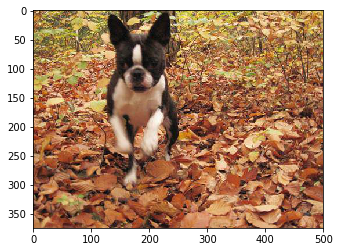

In [18]:
plt.imshow(img)

In [19]:
img.size

562500

In [20]:
img.shape

(375, 500, 3)

In [21]:
image_size = {file: plt.imread(f'{PATH}{file}').shape for file in data.trn_ds.fnames}

In [22]:
height,width,dim = list(zip(*image_size.values()))

In [23]:
height = np.array(height)
width = np.array(width)

(array([ 233.,  736., 2226., 2973., 1787.,   90.,   28.,   33.,    8.,   10.]),
 array([103. , 191.1, 279.2, 367.3, 455.4, 543.5, 631.6, 719.7, 807.8, 895.9, 984. ]),
 <a list of 10 Patch objects>)

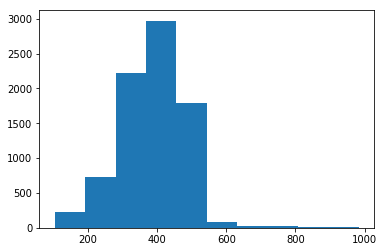

In [24]:
plt.hist(height[height<1000])

(array([ 138.,  592., 1356., 1182., 4572.,  127.,   77.,   53.,   13.,    9.]),
 array([ 97. , 186.3, 275.6, 364.9, 454.2, 543.5, 632.8, 722.1, 811.4, 900.7, 990. ]),
 <a list of 10 Patch objects>)

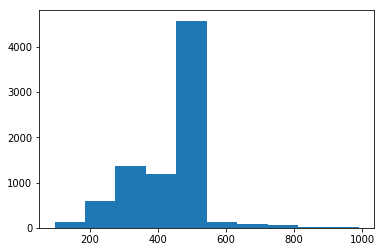

In [25]:
plt.hist(width[width<1000])

In [26]:
len(data.trn_ds)

8178

In [27]:
len(data.test_ds)

10357

In [28]:
#MODEL

In [29]:
learner = ConvLearner.pretrained(arch,data,precompute=True)

In [30]:
#LR FINDER

In [31]:
lr = learner.lr_find()

 82%|████████▏ | 116/141 [00:02<00:00, 31.25it/s, loss=5.48]


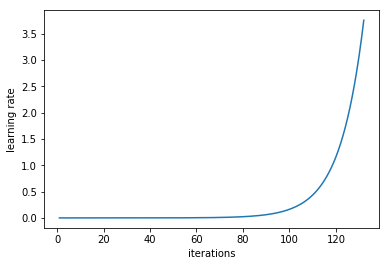

In [32]:
learner.sched.plot_lr()

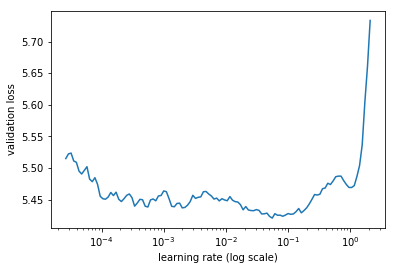

In [33]:
learner.sched.plot()

In [34]:
#PRECOMPUTE

In [35]:
learner.fit(1e-2,2)

epoch      trn_loss   val_loss   accuracy                   
    0      5.279933   4.963234   0.007339  
    1      4.793698   4.954054   0.010274                   



[array([4.95405]), 0.010273972617320118]

In [36]:
#AUGUMENTATIONS

In [37]:
learner.precompute=False

In [38]:
learner.fit(1e-2,3,cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.733273   1.049134   0.85274   
    1      0.804963   0.474893   0.90362                     
    2      0.551863   0.354447   0.919276                    



[array([0.35445]), 0.9192759259922864]

In [39]:
learner.save('224_pre')

In [40]:
learner.load('224_pre')

In [41]:
#UNFREEZE

In [42]:
learner.unfreeze()

In [43]:
lrs = np.array([1e-4,1e-3,1e-2])

In [44]:
#lr = learner.lr_find()

  0%|          | 0/141 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

In [ ]:
#learner.sched.plot()